![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


To make inputs out of this big string of data, we will be splitting it into chunks.

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

-a.

FLORIZEL:
These your unusual weeds to each part of you
Do give a life: no shepherdess, but Flora
Peering in April's front. This your sheep-shearing
Is as a meeting of the petty gods,
And you the q


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=10):#初始值为1
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [4]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [7]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [8]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [9]:
#初始迭代次数：2000
n_epochs =10000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.0005
#初始学习率：0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 9s (100 1%) 3.1250]
Whowy we bmadl ods utw ta.sn the ge kelntre ginnu a sennd tin seaahirde leknd an te wtre tour thiteoth 

 18s (200 2%) 2.6310]
Whind th coe, wor mee he.
 _n goerd

lSS, moutues thee?t han.
ERWind sne an n'd the pine, loole me oei 

 27s (300 3%) 2.4468]
Whh[Iu youdeses or I lepe oo nre mefore bhang arg fouw ou annd acel thy bil of fit mis thos thee thand 

 36s (400 4%) 2.3978]
What mo the our thend she co int weand wenorconde deur nol wectoun sasto the ouk ang, bart him the ne  

 45s (500 5%) 2.4524]
Wheses delil7 lonsang miofy foulndsthe hencour the and.
Bund an ol setand and the be dist ance hist le 

 54s (600 6%) 2.1673]
Whais sher th lar.
Hy bond wat my birt wouce anr abl has, were buxe preat sur and the weren so thand y 

 3s (700 7%) 2.1075]
Whg.

IULAUACEGLO:
Oe int shy and urf har, in cow the altid.

MWok!

Dall blarend iser but oue herthis 

 12s (800 8%) 2.2183]
Whad doger, sod derome an a met bad, Bor sever ound

Por and coficen'd you the a of have wi

 43s (6400 64%) 1.9031]
Whem, when evering he seepin, and come,
The trarked in the burslest in mearce of the go thou had detre 

 52s (6500 65%) 1.8861]
Whow cond hon him see,
And sho?

PEORTES:
I lever and in then brift her ang there she hast her vither  

 1s (6600 66%) 1.7642]
Whicled of ank of and the facising as a nisters
To his hese it.

AALIVA:
And goinisht should shall won 

 10s (6700 67%) 1.9259]
Whome of her is the fort and up your parinisge to it of perepold
his a known of of he pionsioble ears. 

 19s (6800 68%) 1.7744]
Whall not that love and lessat O Marden courbs.
That wing Pillam; a doundry fiends a king of debtain's 

 28s (6900 69%) 1.7149]
Wher lest the conster of thou dedyear for of the good mistrief;
Ctofe it one hatchards and it thee the 

 38s (7000 70%) 1.9251]
What is must amy do tha sirs, I have with whis Thousing this dreait.

LARDIO:
Who is be mersold.
Iw'ti 

 47s (7100 71%) 1.7493]
Whe have you plore,
And her soldack from o' the more anguer our do your hi

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

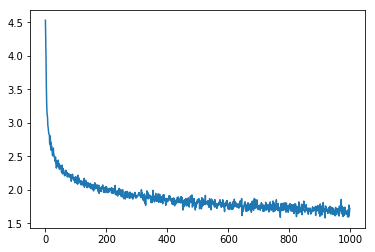

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [11]:
print(evaluate('Th', 200, temperature=0.8))

Thrice as that is and neit be to-
it.

KING HERIOLA:
Of the king, take are my ingris;
And there she speek come your some for me against sir, I have courtamble well him as true the nood for this all see?


Lower temperatures are less varied, choosing only the more probable outputs:

In [12]:
print(evaluate('Th', 200, temperature=0.2))

The grace the come the can the can the sir, the man the come the contersed the so the conter the was the come the maning the grace the put the man the man the see the man the can the see the shall the c


Higher temperatures more varied, choosing less probable outputs:

In [13]:
print(evaluate('Th', 200, temperature=1.4))

Thwatainamich
From forsly
Lolord:
't must not tate I tarm
Lorss'd of am
kince you; Alx he nour now
at qullo oppor,
And gron witty, noireen; herank Honers, no thisal amabo! Sugly laizan Isled
drea-cueth 


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)